In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
import sklearn
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import euclidean_distances
import scipy
import spasne
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sea


## Getting optimal t-SNE embedding

In [2]:
df_data = pd.read_csv('./data/human_BreastCancer1272_data_pc200.csv',sep=",",header=0,na_filter=False,index_col=0) 
df_meta = pd.read_csv('./data/human_BreastCancer1272_meta.csv',sep=",",header=0,na_filter=False,index_col=0)  
df_pixel = df_meta.iloc[:,:2]
# Annotation for calculating ARI
cluster_label = list(df_meta.iloc[:,7])

N = df_data.shape[0]
X = np.array(df_data)
dist_sq = euclidean_distances(X,X)
dist_sq = (dist_sq+dist_sq.T)/2
dist_data = scipy.spatial.distance.squareform(dist_sq)
X_spa = np.array(df_pixel)
dist_sq = euclidean_distances(X_spa,X_spa)
dist_sq = (dist_sq+dist_sq.T)/2
dist_spatial = scipy.spatial.distance.squareform(dist_sq)

alpha = 0
beta = 0
repeats = 100
record_scores = np.zeros((repeats,3))
opt_pos = []
max_score = -1
for repeat in range(repeats):
    spasne_pos = spasne.run_spasne(df_data, pixels = df_pixel, alpha = alpha, beta = beta)
    dist_sq = euclidean_distances(spasne_pos,spasne_pos)
    dist_sq = (dist_sq+dist_sq.T)/2
    dist_model = scipy.spatial.distance.squareform(dist_sq)
    (r1,_) = scipy.stats.pearsonr(dist_data, dist_model)
    (r2,_) = scipy.stats.pearsonr(dist_spatial, dist_model)
    ss = sklearn.metrics.silhouette_score(spasne_pos,cluster_label)
    record_scores[repeat,0] = r1
    record_scores[repeat,1] = r2
    record_scores[repeat,2] = ss
    r1r2 = r1*r2
    if r1r2 > max_score:
        opt_pos = spasne_pos
        max_score = r1r2
df_record_scores = pd.DataFrame(record_scores,columns = ['r1','r2','ss'])
# df_record_scores.to_csv('./human_BreastCancer1272_tsne_opt_scores' + '.csv')
df_opt_pos = pd.DataFrame(opt_pos, columns = ['x_pos','y_pos'])
# df_opt_pos.to_csv('./human_BreastCancer1272_tsne_opt_pos' + '.csv')

## Screening optimal parameters of SpaSNE 

### Rough screening 

In [3]:
GetScore_human_BreastCancer = pd.read_csv('./data/human_BreastCancer1272_tsne_opt_scores.csv',sep=",",header=0,na_filter=False,index_col=0) 
r1_thres = np.mean(list(GetScore_human_BreastCancer['r1']))

df_data = pd.read_csv('./data/human_BreastCancer1272_data_pc200.csv',sep=",",header=0,na_filter=False,index_col=0) 
df_meta = pd.read_csv('./data/human_BreastCancer1272_meta.csv',sep=",",header=0,na_filter=False,index_col=0)  
df_pixel = df_meta.iloc[:,:2]
# Annotation for calculating ARI
cluster_label = list(df_meta.iloc[:,7])

N = df_data.shape[0]
X = np.array(df_data)
dist_sq = euclidean_distances(X,X)
dist_sq = (dist_sq+dist_sq.T)/2
dist_data = scipy.spatial.distance.squareform(dist_sq)
X_spa = np.array(df_pixel)
dist_sq = euclidean_distances(X_spa,X_spa)
dist_sq = (dist_sq+dist_sq.T)/2
dist_spatial = scipy.spatial.distance.squareform(dist_sq)
repeats = 10

spasne_pos = spasne.run_spasne(df_data, pixels = df_pixel, alpha = 0, beta = 0)
dist_sq = euclidean_distances(spasne_pos,spasne_pos)
dist_sq = (dist_sq+dist_sq.T)/2
dist_model = scipy.spatial.distance.squareform(dist_sq)
(r1,_) = scipy.stats.pearsonr(dist_data, dist_model)
(r2,_) = scipy.stats.pearsonr(dist_spatial, dist_model)
ss = sklearn.metrics.silhouette_score(spasne_pos,cluster_label)
df_par = pd.DataFrame([[0,0,r1,r2,ss]],columns = ['alpha','beta','r1','r2','ss'])
for alpha in [2,5,10,20,30,50]:
    for beta in [1,5,10,15,25]:
        record_scores = np.zeros((repeats,5))
        record_scores_max = np.zeros((repeats,1))
        for repeat in range(repeats):
            spasne_pos = spasne.run_spasne(df_data, pixels = df_pixel, alpha = alpha, beta = beta)
            dist_sq = euclidean_distances(spasne_pos,spasne_pos)
            dist_sq = (dist_sq+dist_sq.T)/2
            dist_model = scipy.spatial.distance.squareform(dist_sq)
            (r1,_) = scipy.stats.pearsonr(dist_data, dist_model)
            (r2,_) = scipy.stats.pearsonr(dist_spatial, dist_model)
            if r1 <= r1_thres:
                r1 = 0
            ss = sklearn.metrics.silhouette_score(spasne_pos,cluster_label)
            record_scores[repeat,0] = alpha
            record_scores[repeat,1] = beta
            record_scores[repeat,2] = r1
            record_scores[repeat,3] = r2
            record_scores[repeat,4] = ss
            record_scores_max[repeat,0] = r1*r2
        df_par.loc[len(df_par),:] = record_scores[np.argmax(record_scores_max),:]
#     df_par.to_csv('./human_BreastCancer1272_screenPar_rough' + '.csv')

### Showing heatmap for rough screening results

<AxesSubplot:>

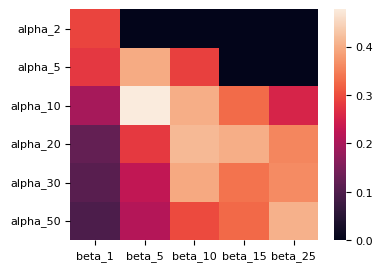

In [4]:
GetScore_human_BreastCancer = pd.read_csv('./data/human_BreastCancer1272_tsne_opt_scores.csv',sep=",",header=0,na_filter=False,index_col=0) 
r1_thres = np.mean(list(GetScore_human_BreastCancer['r1']))

df_pars = pd.read_csv('./data/human_BreastCancer1272_screenPar_rough.csv',sep=",",header=0,na_filter=False,index_col=0) 
r1_values = list(df_pars['r1'][1:])
r2_values = list(df_pars['r2'][1:])
r1r2_values = [r1_values[i]*r2_values[i] for i in range(len(r1_values))]

alpha_range = [2,5,10,20,30,50]
beta_range = [1,5,10,15,25]
col_num = len(beta_range)
col_name = ['beta_'+str(i) for i in beta_range]
df_par_mat = pd.DataFrame([r1r2_values[0:col_num]],columns = col_name)

ct = -1
for alpha in alpha_range:
    ct = ct+1
    df_par_mat.loc[ct,:] = r1r2_values[col_num*ct:col_num*(ct+1)]

df_par_mat.index = ['alpha_'+str(i) for i in alpha_range] 

matplotlib.rcParams['font.size'] = 8
fig, axes = plt.subplots(1, 1, figsize=(4,3))
sz = 10
plot_color=['#911eb4', '#46f0f0','#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231',  '#f032e6', \
            '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', '#ffd8b1', '#800000', '#aaffc3', '#808000', '#000075', '#000000', '#808080', '#ffffff', '#fffac8']
# heatmap of rg x rs values
sea.heatmap(df_par_mat, ax = axes)


### Fine screening

In [5]:
GetScore_human_BreastCancer = pd.read_csv('./data/human_BreastCancer1272_tsne_opt_scores.csv',sep=",",header=0,na_filter=False,index_col=0) 
r1_thres = np.mean(list(GetScore_human_BreastCancer['r1']))

df_data = pd.read_csv('./data/human_BreastCancer1272_data_pc200.csv',sep=",",header=0,na_filter=False,index_col=0) 
df_meta = pd.read_csv('./data/human_BreastCancer1272_meta.csv',sep=",",header=0,na_filter=False,index_col=0)  
df_pixel = df_meta.iloc[:,:2]
# Annotation for calculating ARI
cluster_label = list(df_meta.iloc[:,7])

df_pixel = df_pixel.iloc[:,:2]
N = df_data.shape[0]
X = np.array(df_data)
dist_sq = euclidean_distances(X,X)
dist_sq = (dist_sq+dist_sq.T)/2
dist_data = scipy.spatial.distance.squareform(dist_sq)
X_spa = np.array(df_pixel)
dist_sq = euclidean_distances(X_spa,X_spa)
dist_sq = (dist_sq+dist_sq.T)/2
dist_spatial = scipy.spatial.distance.squareform(dist_sq)
repeats = 20

spasne_pos = spasne.run_spasne(df_data, pixels = df_pixel, alpha = 0, beta = 0)
dist_sq = euclidean_distances(spasne_pos,spasne_pos)
dist_sq = (dist_sq+dist_sq.T)/2
dist_model = scipy.spatial.distance.squareform(dist_sq)
(r1,_) = scipy.stats.pearsonr(dist_data, dist_model)
(r2,_) = scipy.stats.pearsonr(dist_spatial, dist_model)
ss = sklearn.metrics.silhouette_score(spasne_pos,cluster_label)
sr = 0
var = 0
df_par = pd.DataFrame([[0,0,r1,r2,ss,sr,var]],columns = ['alpha','beta','r1','r2','ss','sr','var'])

for alpha in np.arange(5,21,1):
    for beta in np.arange(1,11,1):
        record_scores = np.zeros((repeats,6))
        record_scores_max = np.zeros((repeats,1))
        success_repeat = repeats
        for repeat in range(repeats):
            spasne_pos = spasne.run_spasne(df_data, pixels = df_pixel, alpha = alpha, beta = beta)
            dist_sq = euclidean_distances(spasne_pos,spasne_pos)
            dist_sq = (dist_sq+dist_sq.T)/2
            dist_model = scipy.spatial.distance.squareform(dist_sq)
            (r1,_) = scipy.stats.pearsonr(dist_data, dist_model)
            (r2,_) = scipy.stats.pearsonr(dist_spatial, dist_model)
            if r1 <= r1_thres:
                r1 = 0
                success_repeat = success_repeat - 1
            ss = sklearn.metrics.silhouette_score(spasne_pos,cluster_label)
            record_scores[repeat,0] = alpha
            record_scores[repeat,1] = beta
            record_scores[repeat,2] = r1
            record_scores[repeat,3] = r2
            record_scores[repeat,4] = ss
            record_scores_max[repeat,0] = r1*r2
        record_scores[:,5] = success_repeat/repeats
        var_repeats = np.var(record_scores[:,2])
        df_par.loc[len(df_par),:] = list(record_scores[np.argmax(record_scores_max),:]) + [var_repeats]
#     df_par.to_csv('./human_BreastCancer'+str(N)+'_screenPar_fine' + '.csv')


### Showing heatmap for fine screening results

Optimal parameters by rough screening: alpha_9, beta_4


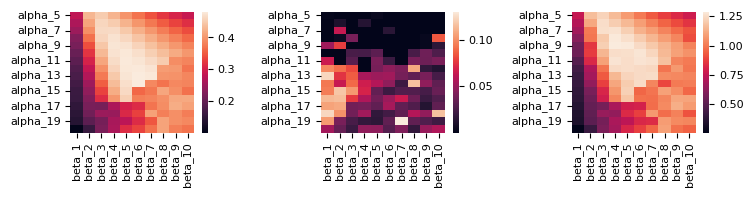

In [6]:
df_pars = pd.read_csv('./data/human_BreastCancer1272_screenPar_fine.csv',sep=",",header=0,na_filter=False,index_col=0) 
r1_values = list(df_pars['r1'][1:])
r2_values = list(df_pars['r2'][1:])
r1r2_values = [r1_values[i]*r2_values[i] for i in range(len(r1_values))]
var_values = list(df_pars['var'][1:])

alpha_range = np.arange(5,21,1)
beta_range = np.arange(1,11,1)

col_num = len(beta_range)
col_name = ['beta_'+str(i) for i in beta_range]
df_par_mat_r1r2 = pd.DataFrame([r1r2_values[0:col_num]],columns = col_name)
df_par_mat_r1 = pd.DataFrame([r1_values[0:col_num]],columns = col_name)
df_par_mat_var = pd.DataFrame([var_values[0:col_num]],columns = col_name)

ct = -1
for alpha in alpha_range:
    ct = ct+1
    df_par_mat_r1r2.loc[ct,:] = r1r2_values[col_num*ct:col_num*(ct+1)]
    df_par_mat_r1.loc[ct,:] = r1_values[col_num*ct:col_num*(ct+1)]
    df_par_mat_var.loc[ct,:] = var_values[col_num*ct:col_num*(ct+1)]
df_par_mat_std = np.sqrt(df_par_mat_var)
df_par_mat_final = np.multiply(df_par_mat_r1r2,np.exp(1-df_par_mat_std))

df_par_mat_r1r2.index = ['alpha_'+str(i) for i in alpha_range] 
df_par_mat_std.index = ['alpha_'+str(i) for i in alpha_range] 
df_par_mat_final.index = ['alpha_'+str(i) for i in alpha_range] 

max_index = np.argmax(df_par_mat_final)
max_row, max_col = np.unravel_index(max_index, df_par_mat_final.shape)
print('Optimal parameters by rough screening: '+ list(df_par_mat_final.index)[max_row]+', '+ list(df_par_mat_final.columns)[max_col])

matplotlib.rcParams['font.size'] = 8
fig, axes = plt.subplots(1, 3, figsize=(7.5,2))
# heatmap of rg x rs values
sea.heatmap(df_par_mat_r1r2, ax = axes[0])
# heatmap of std values
sea.heatmap(df_par_mat_std, ax = axes[1])
# heatmap of rg x rs x exp(1-std) values
sea.heatmap(df_par_mat_final, ax = axes[2])
fig.tight_layout()


### Showing the SpaSNE embedding with optimal parameters

/Applications/anaconda3/envs/spaceflow_env/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  if __name__ == "__main__":


(-1.2914712095826015,
 1.4487787507577656,
 -1.3603204512366196,
 1.3710290438762842)

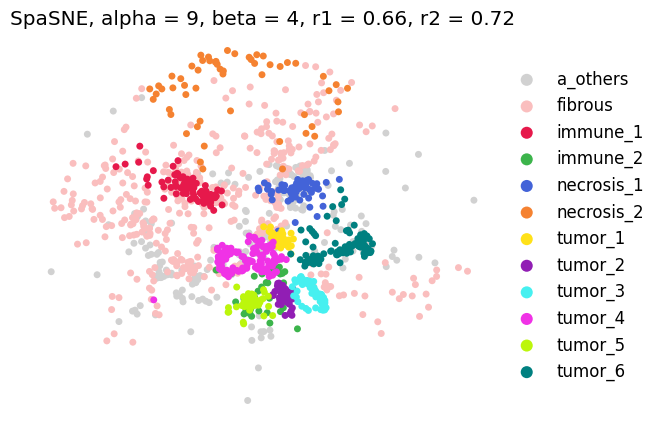

In [7]:
df_data = pd.read_csv('./data/human_BreastCancer1272_data_pc200.csv',sep=",",header=0,na_filter=False,index_col=0) 
df_meta = pd.read_csv('./data/human_BreastCancer1272_meta.csv',sep=",",header=0,na_filter=False,index_col=0)  
df_pos = df_meta.iloc[:,:2]
# Annotation for biological analysis
cluster_label_1 = list(df_meta.iloc[:,3])
# Annotation for calculating ARI
cluster_label = list(df_meta.iloc[:,7])
df_PCs = pd.DataFrame(list(df_data.columns), index = df_data.columns, columns =['PCs'] )
adata = sc.AnnData(X = df_data, obs = df_pos, var = df_PCs)
adata.obs['cell_states'] = cluster_label_1

N = df_data.shape[0]
X = np.array(df_data)
dist_sq = euclidean_distances(X,X)
dist_sq = (dist_sq+dist_sq.T)/2
dist_data = scipy.spatial.distance.squareform(dist_sq)
X_spa = np.array(df_pixel)
dist_sq = euclidean_distances(X_spa,X_spa)
dist_sq = (dist_sq+dist_sq.T)/2
dist_spatial = scipy.spatial.distance.squareform(dist_sq)


alpha = 9
beta = 4
spasne_pos = spasne.run_spasne(df_data, pixels = df_pixel, alpha = alpha, beta = beta,randseed = 1)
dist_sq = euclidean_distances(spasne_pos, spasne_pos)
dist_sq = (dist_sq + dist_sq.T)/2
dist_model = scipy.spatial.distance.squareform(dist_sq)
(r1,_) = scipy.stats.pearsonr(dist_data, dist_model)
(r2,_) = scipy.stats.pearsonr(dist_spatial, dist_model)
ss = sklearn.metrics.silhouette_score(spasne_pos,cluster_label)
quant_eval_spasne = [r1,r2,ss]

adata.obs['spasne_pos_x'] = spasne_pos[:,0]
adata.obs['spasne_pos_y'] = spasne_pos[:,1]

plot_color=['#D1D1D1','#fabebe','#e6194b','#3cb44b', '#4363d8', '#f58231','#ffe119',  '#911eb4', '#46f0f0', '#f032e6', \
            '#bcf60c',  '#008080', '#e6beff', '#9a6324', '#ffd8b1', '#800000', '#aaffc3', '#808000', '#000075', '#000000', '#808080', '#ffffff', '#fffac8']
matplotlib.rcParams['font.size'] = 12.0
fig, axes = plt.subplots(1, 1, figsize=(6,5))
sz = 100
domains="cell_states"
num_celltype=len(adata.obs[domains].unique())
adata.uns[domains+"_colors"]=list(plot_color[:num_celltype])
titles = 'SpaSNE, '+'alpha = '+str(alpha)+ ', beta = '+str(beta) + ', r1 = %.2f'% quant_eval_spasne[0] + ', r2 = %.2f'%quant_eval_spasne[1] 

ax=sc.pl.scatter(adata,alpha=1,x="spasne_pos_x",y="spasne_pos_y",color=domains,title=titles,color_map=plot_color,show=False,size=sz,ax = axes)
ax.axis('off')